In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
METRIC = 'long10'
INSTRUMENT = 'EUR_USD'
GRANULARITY = 1
IMAGE_DIR = 'images/%s_%s_%s/' % (GRANULARITY, INSTRUMENT, METRIC)
TRAIN_DIR = IMAGE_DIR + 'train'
TEST_DIR = IMAGE_DIR + 'test'

batch_size = 32
img_height = 434
img_width = 422

In [3]:
# load data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=(img_height, img_width), validation_split=0.2,
    subset="training", seed=123, batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=(img_height, img_width), validation_split=0.2,
    subset="validation", seed=123, batch_size=batch_size
)

Found 54686 files belonging to 2 classes.
Using 43749 files for training.


2021-12-02 09:01:30.727088: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 54686 files belonging to 2 classes.
Using 10937 files for validation.


In [4]:
# calculate class weights
total = 0
count_1 = 0
for batch in train_ds:
    total += len(batch[1])
    count_1 += sum(batch[1].numpy())

class_weight = {
    0: (1 / (total - count_1)) * (total / 2.0),
    1: (1 / count_1) * (total / 2.0)
} 

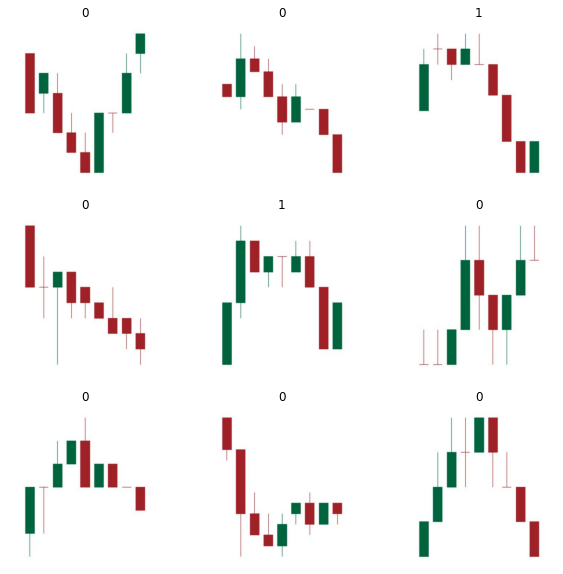

In [5]:
# visualize data
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# standardize data
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2021-11-29 21:05:22.356211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 282 of 1000
2021-11-29 21:05:32.323979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 443 of 1000
2021-11-29 21:05:42.363752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 599 of 1000
2021-11-29 21:05:52.359887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 754 of 1000
2021-11-29 21:06:02.344748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 914 of 1000
2021-11-29 21:06:07.581524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2021-11-29 21:06:08.135000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cac

0.0 1.0


In [8]:
# initialize model
num_classes = 2

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 434, 422, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 434, 422, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 217, 211, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 217, 211, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 108, 105, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 105, 64)      1

In [9]:
# train model
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    class_weight=class_weight
)

Epoch 1/10


2021-11-29 21:08:14.658233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 276 of 1000
2021-11-29 21:08:24.667978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 425 of 1000
2021-11-29 21:08:34.710269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 554 of 1000
2021-11-29 21:08:44.690254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 707 of 1000
2021-11-29 21:08:54.673814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 859 of 1000
2021-11-29 21:09:04.098447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


1368/1368 [==============================] - 2183s 2s/step - loss: 0.7446 - accuracy: 0.5027 - val_loss: 0.6922 - val_accuracy: 0.5686
Epoch 2/10
1368/1368 [==============================] - 2159s 2s/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6933 - val_accuracy: 0.4314
Epoch 3/10
1368/1368 [==============================] - 2211s 2s/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6914 - val_accuracy: 0.5686
Epoch 4/10
1368/1368 [==============================] - 2104s 2s/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6936 - val_accuracy: 0.4314
Epoch 5/10
1368/1368 [==============================] - 2110s 2s/step - loss: 0.6932 - accuracy: 0.4757 - val_loss: 0.6913 - val_accuracy: 0.5686
Epoch 6/10
1368/1368 [==============================] - 2108s 2s/step - loss: 0.6932 - accuracy: 0.5226 - val_loss: 0.6955 - val_accuracy: 0.4314
Epoch 7/10
1368/1368 [==============================] - 2127s 2s/step - loss: 0.6932 - accuracy: 0.4825 - val_loss: 0.6923 - val_accura

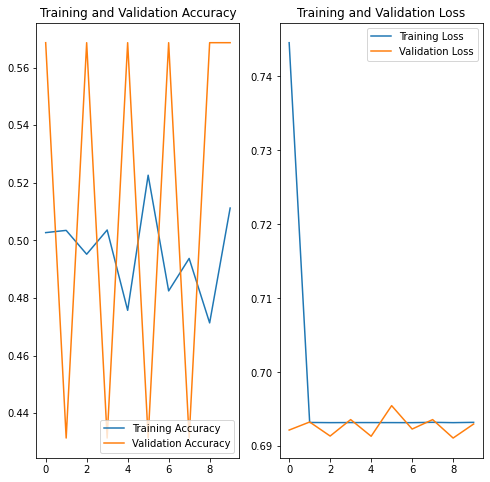

In [10]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
num_classes = 2

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

# train model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    class_weight=class_weight
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 434, 422, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 434, 422, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 217, 211, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 217, 211, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 108, 105, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 108, 105, 64)     

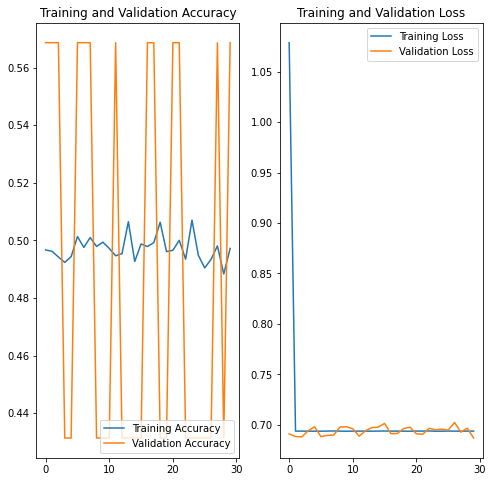

In [32]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy


In [47]:
data = ImageDataLoaders.from_folder(
    IMAGE_DIR,
    valid_pct=0.3,
    size=224,
    bs=32,
    num_workers=0
)

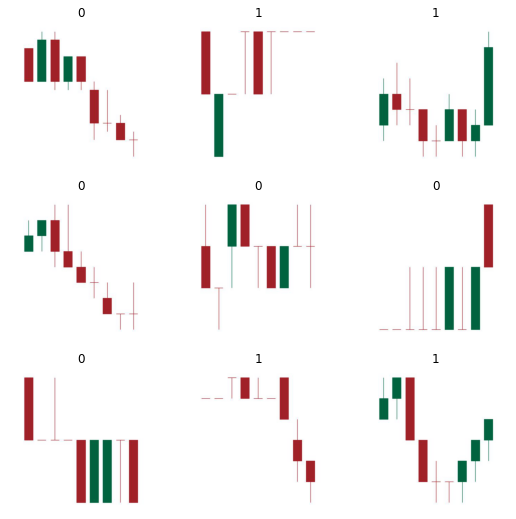

In [48]:
data.show_batch()

In [45]:
# See the number of images in each data set
print(len(data.train_ds), len(data.valid_ds))

38281 16405


In [49]:
learn = cnn_learner(data, models.resnet34, metrics = [accuracy])
# Train the model on 4 epochs of data at the default learning rate
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.725023,0.705013,0.560073,8:48:10
1,0.710384,0.692665,0.539531,8:47:14
2,0.692996,0.687411,0.554770,8:45:48
3,0.688320,0.684894,0.566108,8:48:32


In [53]:
learn.save('model-0')

Path('images/1_EUR_USD_long10/models/model-0.pth')

In [55]:
interp = ClassificationInterpretation.from_learner(learn)

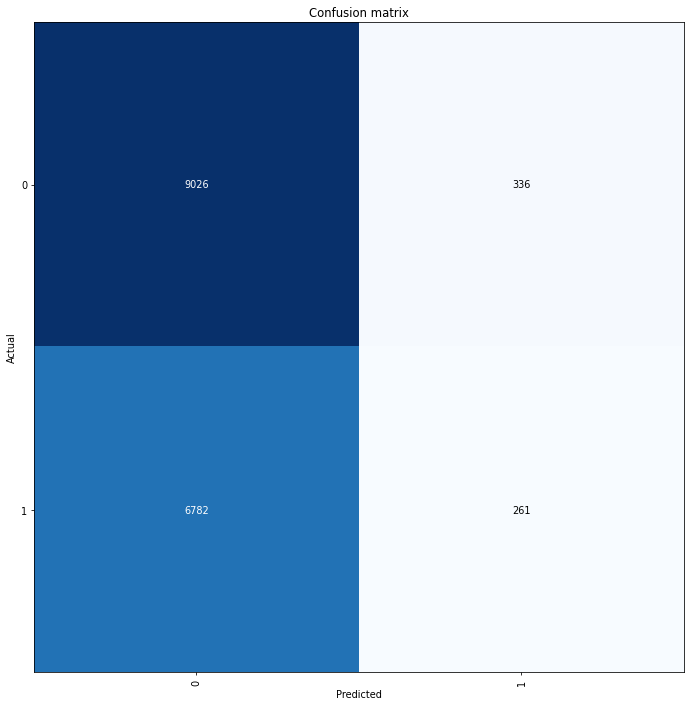

In [60]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=70)

In [61]:
# Unfreeze all layers of the CNN
learn.unfreeze()

In [62]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

KeyboardInterrupt: 